In [ ]:
%reset -sf
import random
import collections
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm

random.seed(42)

In [ ]:
REARRANGE_FOR_MERGE = True
MERGE_WINDOW = 10000
ARRANGE_WINDOW = 10000

In [ ]:
filepath = "d_pet_pictures.txt"
with open(filepath) as f:
    pictures = [row.strip().split() for row in f.readlines()][1:]

In [ ]:
pic_tags = {}  # maps idx to tags
horizontal_photos = []  # horizontal photos only
vertical_photos = []  # vertical photos only
for i,picture in enumerate(pictures):
    pic_tags[i] = set(picture[2:])
    if picture[0] == "H":
        horizontal_photos.append(i)
    elif picture[0] == "V":
        vertical_photos.append(i)
print(len(vertical_photos), len(horizontal_photos))

60000 30000


In [ ]:
def calc_tags_pair_score(tags1, tags2):
    # given two sets of tags, calculate the score
    return min(len(tags1 & tags2), len(tags1 - tags2), len(tags2 - tags1))

def calc_idxs_pair_score(idxs1, idxs2):
    # given two tuples of indices, calculate the score
    return calc_tags_pair_score(
        set.union(*[pic_tags[idx] for idx in idxs1]),
        set.union(*[pic_tags[idx] for idx in idxs2]))

def calc_idxs_pair_score_max(idxs1, idxs2):
    # given two tuples of indices, calculate the maximum possible score by tag length
    return min(len(set.union(*[pic_tags[idx] for idx in idxs1])),
               len(set.union(*[pic_tags[idx] for idx in idxs2])))//2

def calc_sequence(idxs_lst):
    # given the sequence of indices, calculate the score
    check_validity(idxs_lst)
    score = 0
    for before, after in zip(idxs_lst[:-1], idxs_lst[1:]):
        score += calc_idxs_pair_score(before, after)
    return score

def calc_sequence_max(idxs_lst):
    # given the sequence of indices, calculate the score
    check_validity(idxs_lst)
    score = 0
    for before, after in zip(idxs_lst[:-1], idxs_lst[1:]):
        score += calc_idxs_pair_score_max(before, after)
    return score

def check_validity(idxs_lst):
    all_pics = [idx for idxs in idxs_lst for idx in idxs]
    if len(all_pics) != len(set(all_pics)):
        print("Duplicates found")
    all_verts = [idx for idxs in idxs_lst for idx in idxs if len(idxs) == 2]
    if (set(all_verts) - set(vertical_photos)):
        print("Horizontal photos found in vertical combinations")
    all_horis = [idx for idxs in idxs_lst for idx in idxs if len(idxs) == 1]
    if (set(all_horis) - set(horizontal_photos)):
        print("Vertical photos found in horizontal arrangement")

In [ ]:
idxs_list = [(a,b) for a,b in zip(vertical_photos[0::2], vertical_photos[1::2])]
idxs_list.extend([(a,) for a in horizontal_photos])
calc_sequence(idxs_list), calc_sequence_max(idxs_list), len(idxs_list)

(190962, 331505, 60000)

In [ ]:
random.shuffle(idxs_list)
idxs_list.sort(key = lambda idxs: sum([len(pic_tags[idx]) for idx in idxs]))
calc_sequence(idxs_list), calc_sequence_max(idxs_list), len(idxs_list)

(211820, 404300, 60000)

In [ ]:
# match vertical photos by tag length
random.shuffle(vertical_photos)
vertical_photos.sort(key=lambda idx: len(pic_tags[idx]))
idxs_list = [(a,b) for a,b in zip(vertical_photos[0::2], vertical_photos[1::2])]
idxs_list.extend([(a,) for a in horizontal_photos])
idxs_list.sort(key = lambda idxs: sum([len(pic_tags[idx]) for idx in idxs]))
calc_sequence(idxs_list), calc_sequence_max(idxs_list), len(idxs_list)

(217021, 401509, 60000)

In [ ]:
vertical_tmp = vertical_photos[::-1]  # start from photo with most tags
if REARRANGE_FOR_MERGE:
    # so we can easily match photos with more tags with photos with less tags
    vertical_photos[0::2] = vertical_tmp[:30000]
    vertical_photos[1::2] = vertical_tmp[30000:][::-1]
vertical_tmp = vertical_photos
vertical_photos = [vertical_tmp[0]]
vertical_tmp = vertical_tmp[1:]

for i in tqdm(range(len(vertical_tmp))):
    idxs1 = vertical_photos[-1]
    best = -9999
    best_next_ptr = 0
    cnt = 0
    for j,idxs2 in enumerate(vertical_tmp):
        if len(vertical_photos)%2 == 0:  # we do not need to consider between pairs
            break
        if best == 0:
            # we have found an optimal match
            break
        if cnt > MERGE_WINDOW:
            # early stopping in the search for a paired photo
            break
        score = -len(pic_tags[idxs1] & pic_tags[idxs2])
        num_tags_if_paired = len(pic_tags[idxs1] | pic_tags[idxs2])
        if num_tags_if_paired%2 == 1:
            # penalise if the total number of tags is odd
            score = min(score,-0.9)
        if num_tags_if_paired > 22 and REARRANGE_FOR_MERGE:
            # to encourage the total number of tags around 22
            score = min(score,-0.02*num_tags_if_paired)
        if score > best:
            best = score
            best_next_ptr = j
        cnt += 1
    vertical_photos.append(vertical_tmp[best_next_ptr])
    vertical_tmp = vertical_tmp[:best_next_ptr] + vertical_tmp[best_next_ptr+1:]

100%|██████████| 59999/59999 [03:51<00:00, 259.31it/s]  


In [ ]:
# match vertical photos by tag length
idxs_list = [(a,b) for a,b in zip(vertical_photos[0::2], vertical_photos[1::2])]
idxs_list.extend([(a,) for a in horizontal_photos])
idxs_list.sort(key = lambda idxs: sum([len(pic_tags[idx]) for idx in idxs]))
calc_sequence(idxs_list), calc_sequence_max(idxs_list), len(idxs_list)

(241016, 443387, 60000)

In [ ]:
idxs_list_tmp = idxs_list
idxs_list = [idxs_list_tmp[0]]
idxs_list_tmp = idxs_list_tmp[1:]

for i in tqdm(range(len(idxs_list_tmp))):
    idxs1 = idxs_list[-1]
    best = -1
    best_next_ptr = -1
    cnt = 0
    for j,idxs2 in enumerate(idxs_list_tmp):
        if cnt > ARRANGE_WINDOW:
            # early stopping in the greedy search
            break
        if best == sum(len(pic_tags[idx]) for idx in idxs2)//2:
            # if we have reached the maximum possible score for the next neighbour
            break
        score = calc_idxs_pair_score(idxs1,idxs2)
        if score > best:
            best = score
            best_next_ptr = j
        cnt += 1
    idxs_list.append(idxs_list_tmp[best_next_ptr])
    idxs_list_tmp = idxs_list_tmp[:best_next_ptr] + idxs_list_tmp[best_next_ptr+1:]

100%|██████████| 59999/59999 [04:06<00:00, 243.86it/s]


In [ ]:
calc_sequence(idxs_list), calc_sequence_max(idxs_list), len(idxs_list)

(441278, 441486, 60000)

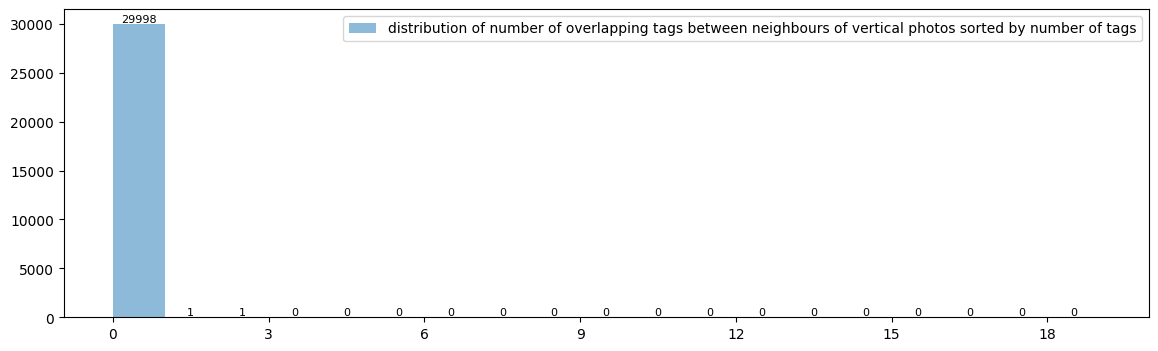

In [ ]:
plt.figure(figsize=(14,4))
plt.hist([len(pic_tags[idx1] & pic_tags[idx2]) for idx1,idx2 in
          zip(vertical_photos[::2], vertical_photos[1::2])], bins=range(20), alpha=0.5,
         label="distribution of number of overlapping tags " +
               "between neighbours of vertical photos sorted by number of tags")
for rect in plt.gca().patches:
    height = rect.get_height()
    plt.gca().annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height),
                       xytext=(0, 0), textcoords='offset points',
                       ha='center', va='bottom', fontsize=8)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.show()

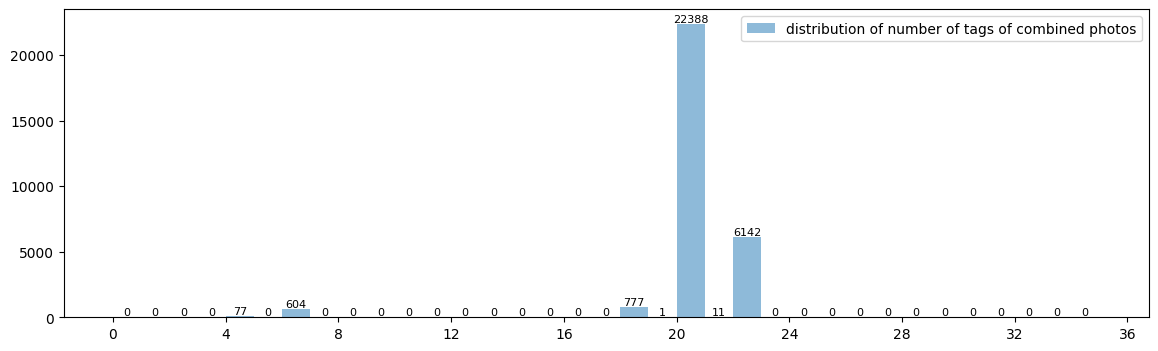

In [ ]:
plt.figure(figsize=(14,4))
plt.hist([len(pic_tags[idxs[0]] | pic_tags[idxs[1]])
          for idxs in zip(vertical_photos[::2], vertical_photos[1::2])],
         bins=range(36), alpha=0.5,
         label="distribution of number of tags of combined photos")
for rect in plt.gca().patches:
    height = rect.get_height()
    plt.gca().annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height),
                       xytext=(0, 0), textcoords='offset points',
                       ha='center', va='bottom', fontsize=8)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.show()

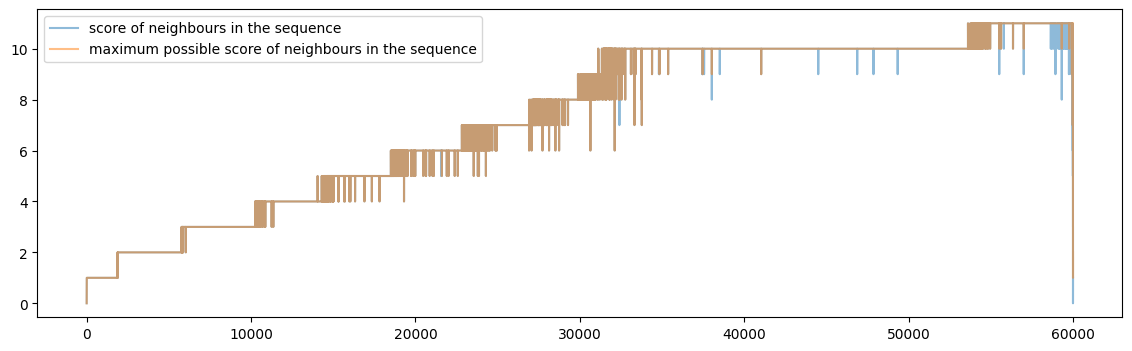

In [ ]:
plt.figure(figsize=(14,4))
plt.plot([calc_idxs_pair_score(idxs1,idxs2) for idxs1,idxs2 in
          zip(idxs_list[:-1], idxs_list[1:])], alpha=0.5,
         label="score of neighbours in the sequence")
plt.plot([calc_idxs_pair_score_max(idxs1,idxs2) for idxs1,idxs2 in
          zip(idxs_list[:-1], idxs_list[1:])], alpha=0.5,
         label="maximum possible score of neighbours in the sequence")
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.show()

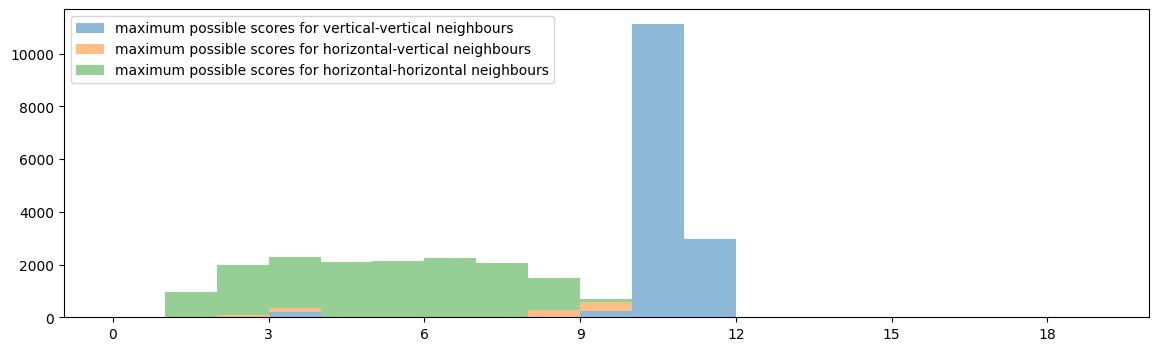

In [ ]:
plt.figure(figsize=(14,4))
plt.hist([[calc_idxs_pair_score_max(idxs1,idxs2) for idxs1,idxs2 in
          zip(idxs_list[::2], idxs_list[1::2]) if len(idxs1) + len(idxs2) == 4],
          [calc_idxs_pair_score_max(idxs1,idxs2) for idxs1,idxs2 in
          zip(idxs_list[::2], idxs_list[1::2]) if len(idxs1) + len(idxs2) == 3],
          [calc_idxs_pair_score_max(idxs1,idxs2) for idxs1,idxs2 in
          zip(idxs_list[::2], idxs_list[1::2]) if len(idxs1) + len(idxs2) == 2]],
         bins=range(20), alpha=0.5,
         label=[
        "maximum possible scores for vertical-vertical neighbours",
        "maximum possible scores for horizontal-vertical neighbours",
        "maximum possible scores for horizontal-horizontal neighbours"],
         stacked=True)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.show()

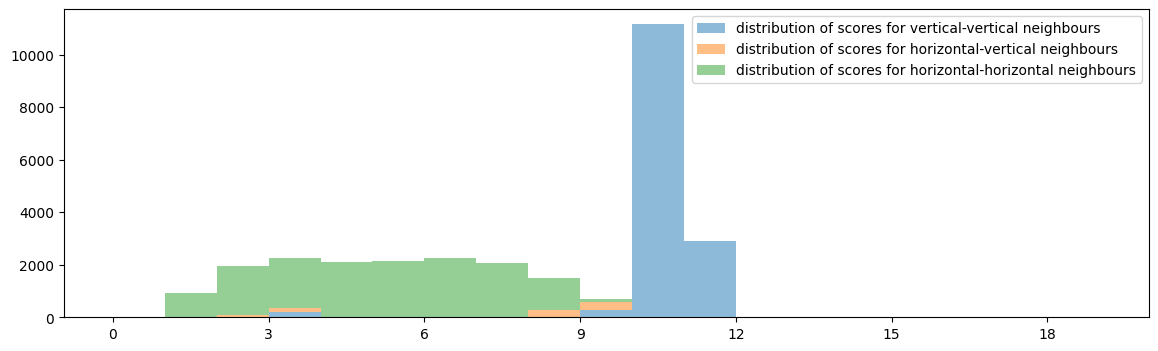

In [ ]:
plt.figure(figsize=(14,4))
plt.hist([[calc_idxs_pair_score(idxs1,idxs2) for idxs1,idxs2 in
          zip(idxs_list[::2], idxs_list[1::2]) if len(idxs1) + len(idxs2) == 4],
          [calc_idxs_pair_score(idxs1,idxs2) for idxs1,idxs2 in
          zip(idxs_list[::2], idxs_list[1::2]) if len(idxs1) + len(idxs2) == 3],
          [calc_idxs_pair_score(idxs1,idxs2) for idxs1,idxs2 in
          zip(idxs_list[::2], idxs_list[1::2]) if len(idxs1) + len(idxs2) == 2]],
         bins=range(20), alpha=0.5,
         label=[
        "distribution of scores for vertical-vertical neighbours",
        "distribution of scores for horizontal-vertical neighbours",
        "distribution of scores for horizontal-horizontal neighbours"],
         stacked=True)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.show()